# Soccer Player Position Prediction

**Table of Contents:**

- Introduction
    - Import data
    - Relabeling the target variable
- Exploring outlier detection methods
    - Preparing outlier detection method analysis
    - DBSCAN
    - Principal Component Analysis and reconstruction error
    - Isolation Forest
    - Minimum covariance determinant
    - Local Outlier Factor
- Models with outlier removal
    - Outlier removal: base model
    - Outlier removal: DBSCAN
    - Outlier removal: Principal Component Analysis and reconstruction error
    - Outlier removal: Isolation Forest
    - Outlier removal: Minimum covariance determinant
    - Outlier removal: Local Outlier Factor
- Final prediction model


## Introduction

What if we could use data science to predict a player's best position? That is exactly what I will do in this project.

When buying or hiring a player, the technical staff and the coach often have a position for the player in mind. Also, when some players in the team are injured, a specific player may play on another position than he is used to. An interesting business problem therefore is whether we can use the attribute ratings from the popular FIFA computer games to predict the players' best position. And to predict the players' next best position. In this project I am going to build a prediction model which can do this. 

Data on player attributes are generally unavailable. However, for the FIFA computer games, data on quality attributes are collected via many individual raters around the world. These raters rate players based on 35 attributes, such crossing, finishing, and heading accuracy. Based on these attribute ratings, overall scores are calculated for the FIFA game. Click [here](https://www.earlygame.com/fifa/fifa-ratings-explained-overall-rating) or [here](https://www.goal.com/en-ae/news/fifa-player-ratings-explained-how-are-the-card-number-stats/1hszd2fgr7wgf1n2b2yjdpgynu) to find out more about the rating process of the FIFA computer game.

To achieve a better prediction model, I will consider incorporating outlier detection and deletion in the pipeline. Some players are considered more unique than others and deleting these players from the training data might actually lead to a better prediction model. I will examine five outlier (anomaly) detection models:
- DBSCAN
- PCA and reconstruction errors
- Isolation Forest
- Miminum Covariance Determinant
- Local Outlier Factor

I first explore these anomaly detection methods based on the total FIFA population and see what type of players are being labeled as outlier. Then I use the methods in the pipeline with a logit model to see which of the methods leads to the best result on the cross validation test data. Finally, I will choose the best model and make some predictions!

Let us first import the data, which can be obtained from [here](https://www.kaggle.com/karangadiya/fifa19).

### Import data

In [1]:
import os
os.chdir("D:\Projects\FIFA2019")

In [2]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn import FunctionSampler
from imblearn.pipeline import Pipeline
%matplotlib inline

In [3]:
data = pd.read_csv("data.csv")

In [4]:
data.head(5)

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

Goalkeepers are so much different from the field players, that we will not consider them. Furthermore, we will only consider the attribute ratings that relate to the field players.

In [6]:
# delete players that are goal keeper or where the position is not known

data = data[data["Position"]!="GK"]
data = data[data["Position"].notna()]

In [7]:
# define a list with the player attribute rating column names and drop observations that do not have enough data. 

player_attributes = ["Crossing", "Finishing", "HeadingAccuracy", "ShortPassing", "Volleys", "Dribbling", "Curve", "FKAccuracy",
          "LongPassing", "BallControl", "Acceleration", "SprintSpeed", "Agility", "Reactions", "Balance", "ShotPower", "Jumping",
          "Stamina", "Strength", "LongShots", "Aggression", "Interceptions", "Positioning", "Vision", "Penalties", "Composure",
          "Marking", "StandingTackle", "SlidingTackle"]

data = data.dropna(subset=player_attributes)

In [8]:
print(f"The dataset now has {data.shape[0]} rows and {data.shape[1]} columns.")

The dataset now has 16122 rows and 89 columns.


### Relabeling the target variable

The target variable in this project will be the player's position. As the player attributes are very unlikely be able to predict the position's side of the field (left or right), I reclassify the labels accordingly. Furthermore, some of the labels, such as back or wing back, basically boil down to the same thing, although football coaches might disagree (might depend on the [play system](https://en.wikipedia.org/wiki/Defender_(association_football))). I therefore also aggregate some of the positions. Of course, this re-classiying is somewhat subjective.

The 8 positions that we will use for our analysis are:
- B: Back ( Left / Right / Full / Wing)
- CB: Centre Back
- W: Wing (Left Wing / Right Wing / Left Forward / Right Forward)
- M: Mid (Left Mid / Right Mid)
- CM: Centre Mid
- CAM: Centre Attacking Mid
- CDM: Centre Defensive Mid
- ST: striker (Centre Forward / Left Striker / Right Striker)

In [9]:
# original positions in FIFA dataset
data["Position"].unique()

array(['RF', 'ST', 'LW', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB', 'LDM',
       'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM', 'RW',
       'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

GK - Goalkeeper
RB - Right Back
RWB - Right Wing Back
CB - Centre Back
LWB - Left Wing Back
LB - Left Back
CM - Centre Mid
CDM - Centre Defensive Mid
CAM - Centre Attacking Mid
RM - Right Mid
LM - Left Mid
LW - Left Wing
RW - Right Wing
CF - Centre Forward
LF - Left Forward
RF - Right Forward
ST - Striker

In [10]:
# relabeling the target variable in 8 categories
data['Position'] = data['Position'].map({'CAM': 'CAM','CB': 'CB', 'CDM': 'CDM',
                                      'CM': 'CM','LB': 'B_LR','LM': 'M_LR','LW': 'W_LR',
                                      'RB': 'B_LR','RM': 'M_LR','RW': 'W_LR','ST': 'ST',
                                      'CF': 'ST','LAM': 'CAM','LCB': 'CB','LCM': 'CM',
                                      'LDM': 'CDM','LF': 'W_LR','LS': 'ST', 'LWB': 'B_LR',
                                      'RAM': 'CAM', 'RCB': 'CB','RCM': 'CM', 'RDM': 'CDM',
                                      'RF': 'W_LR', 'RS': 'ST','RWB': 'B_LR'})

In [11]:
data["Position"].unique()

array(['W_LR', 'ST', 'CM', 'CB', 'CDM', 'CAM', 'M_LR', 'B_LR'],
      dtype=object)

In [12]:
data["Position"].value_counts(normalize=True)

CB      0.191540
B_LR    0.172311
ST      0.163503
M_LR    0.137638
CM      0.135219
CDM     0.089257
CAM     0.062027
W_LR    0.048505
Name: Position, dtype: float64

## Exploring outlier detection methods

Before I am going to predict a player's position and choose an outlier detection method to incorporate in the workflow (if it performs well), let us first examine the outlier detection methods in more detail. 

I will run all models on the total FIFA population and examine what type of players are detected as an outlier. For this, I need some player characteristics to evaluate on. These player characteristics are:
- International reputation
- Position
- Age
- Overall score
- Weight
- Hight
- Nationality

As we will see, the anomaly detection algorithms often do not randomly select anomalies along these dimensions.

### Preparing outlier detection method analysis

Let us first examine several player dimensions which I use to compare the outliers with the overal FIFA population. These dimensions are international reputation, position, age, overall score, weight, hight and nationality. Where necessary, I transform the format of a variable into a format that I can work with.

In [13]:
# international reputation 
data["International Reputation"].value_counts(normalize=True)

1.0    0.908324
2.0    0.071269
3.0    0.017306
4.0    0.002791
5.0    0.000310
Name: International Reputation, dtype: float64

In [14]:
# age
data["Age"].describe()

count    16122.000000
mean        25.005272
std          4.547106
min         16.000000
25%         21.000000
50%         25.000000
75%         28.000000
max         41.000000
Name: Age, dtype: float64

In [15]:
# Overall score
data["Overall"].describe()

count    16122.000000
mean        66.461233
std          6.794631
min         46.000000
25%         62.000000
50%         66.000000
75%         71.000000
max         94.000000
Name: Overall, dtype: float64

In [16]:
# Weight
data["Weight"].value_counts().head(10)

154lbs    1398
165lbs    1368
159lbs     915
161lbs     896
172lbs     866
163lbs     857
176lbs     838
170lbs     785
168lbs     754
150lbs     653
Name: Weight, dtype: int64

In [17]:
# Transform weight to a numerical variable
data["Weight_lbs"] = data["Weight"].str[0:3].astype(int)

In [18]:
# Height
data["Height"].value_counts().sort_index()

5'1        3
5'10    2444
5'11    2054
5'2        5
5'3       18
5'4       30
5'5      145
5'6      316
5'7      903
5'8      942
5'9     2226
6'0     2609
6'1     1588
6'2     1531
6'3      661
6'4      457
6'5      133
6'6       42
6'7       12
6'8        3
Name: Height, dtype: int64

In [19]:
# Transform height to a numerical variable
data["Height_inch"] = data["Height"].map({"5'1": 61, "5'2":62, "5'3": 63, "5'4": 64, "5'5": 65, "5'6": 66, "5'7": 67,
                                         "5'8": 68, "5'9": 69, "5'10": 70, "5'11": 71, "6'0": 72, "6'1": 73, "6'2": 74,
                                         "6'3": 75, "6'4": 76, "6'5": 77, "6'6": 78, "6'7": 79, "6'8": 80})

In [20]:
data["Height_inch"].value_counts()

72    2609
70    2444
69    2226
71    2054
73    1588
74    1531
68     942
67     903
75     661
76     457
66     316
65     145
77     133
78      42
64      30
63      18
79      12
62       5
61       3
80       3
Name: Height_inch, dtype: int64

In [21]:
# Nationality
data["Nationality"].value_counts(normalize=True).head(25)

England                0.091986
Germany                0.063950
Spain                  0.059236
Argentina              0.052041
France                 0.050242
Brazil                 0.046954
Italy                  0.037650
Colombia               0.034983
Japan                  0.025865
Netherlands            0.024563
Sweden                 0.021709
Chile                  0.021461
China PR               0.020903
Republic of Ireland    0.020407
Mexico                 0.019787
Norway                 0.019228
Denmark                0.018608
Korea Republic         0.018174
Saudi Arabia           0.017988
Portugal               0.017988
Poland                 0.017926
United States          0.017430
Scotland               0.016251
Turkey                 0.015879
Austria                0.015631
Name: Nationality, dtype: float64

Now that we have seen the dimensions, let's create a plot function that plots the sample characteristics along these dimensions of the detected ouliers compared to the sample characteristics of the total FIFA populations.

In [22]:
def plot_outliers_vs_population(outliers, population, title="set title"):
    fig = plt.figure(constrained_layout=False, figsize=(15,15))
    fig.suptitle(title, fontsize=16)
    gs = fig.add_gridspec(4,2, top=0.93, bottom=0.1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title("International Reputation")
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title("Position")
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.set_title("Age")
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_title("Overall score")
    ax6 = fig.add_subplot(gs[2, 0])
    ax6.set_title("Weight in lbs")
    ax7 = fig.add_subplot(gs[2, 1])
    ax7.set_title("Height in inches")
    ax5 = fig.add_subplot(gs[3, :])
    ax5.set_title("Nationality")
    
    # International reputation
    df_ir = pd.DataFrame({"proportion": population["International Reputation"].value_counts(normalize=True).sort_index(),
                          "data": "Total population",
                          "International Reputation": population["International Reputation"].value_counts().sort_index().index.astype(int)})
    
    df_ir_outliers = pd.DataFrame({"proportion": outliers["International Reputation"].value_counts(normalize=True).sort_index(),
                                   "data": "Sample of outliers",
                                   "International Reputation": outliers["International Reputation"].value_counts().sort_index().index.astype(int)})
    df_ir = df_ir.append(df_ir_outliers)
    df_ir = df_ir.fillna(0)
    sns.barplot(x="International Reputation", y="proportion", hue="data", data=df_ir, ax=ax1)
    
    # Position
    df_pos = pd.DataFrame({"proportion": population["Position"].value_counts(normalize=True).sort_index(),
                          "data": "Total population",
                          "Position": population["Position"].value_counts().sort_index().index})
    df_pos_outliers = pd.DataFrame({"proportion": outliers["Position"].value_counts(normalize=True).sort_index(),
                                    "data": "Sample of outliers",
                                    "Position": outliers["Position"].value_counts().sort_index().index})
    df_pos = df_pos.append(df_pos_outliers)
    sns.barplot(x="Position", y="proportion", hue="data", data=df_pos, ax=ax2)
    
    # Age
    sns.kdeplot(x=population["Age"], color="blue", shade=True, ax=ax3)
    sns.kdeplot(x=outliers["Age"], color="orange", shade=True, ax=ax3)

    # Overall score
    sns.kdeplot(x=population["Overall"], color="blue", shade=True, ax=ax4)
    sns.kdeplot(x=outliers["Overall"], color="orange", shade=True, ax=ax4)
    
    # Nationality top 20 population
    df_nat_population = pd.DataFrame({"proportion_population": population["Nationality"].value_counts(normalize=True).sort_index(),
                          "Nationality_population": population["Nationality"].value_counts().sort_index().index})
    df_nat_outliers = pd.DataFrame({"proportion_outliers": outliers["Nationality"].value_counts(normalize=True).sort_index(),
                                    "Nationality_outliers": outliers["Nationality"].value_counts().sort_index().index})
    df_nat = df_nat_population.merge(df_nat_outliers, left_index=True, right_index=True)

    df_nat_population["rank"] = df_nat_population["proportion_population"].rank(ascending=False)
    df_nat_population = df_nat_population.sort_values(by="proportion_population", ascending=True)
    df_nat_population["cumsum_proportion_population"] = df_nat_population["proportion_population"].cumsum()
    df_nat_population["other"] = df_nat_population["rank"] >= 21

    df_nat = df_nat_population.merge(df_nat_outliers, left_index=True, right_index=True)
    df_nat = df_nat.sort_values(by="rank", ascending=False)
    df_nat["cumsum_proportion_outliers"] = df_nat["proportion_outliers"].cumsum()
    df_nat_other = df_nat[df_nat["other"]]
    df_nat_other = df_nat_other.tail(1)
    df_nat = df_nat[df_nat["other"]!=True]

    df_nat_population = pd.DataFrame({"proportion": df_nat["proportion_population"],
                                      "data": "Total population",
                                      "Nationality": df_nat["Nationality_population"]})
    df_nat_outliers = pd.DataFrame({"proportion": df_nat["proportion_outliers"],
                                    "data": "Sample of outliers",
                                    "Nationality": df_nat["Nationality_outliers"]})
    df_nat_other_population = pd.DataFrame({"proportion": df_nat_other["cumsum_proportion_population"],
                                            "data": "Total population",
                                            "Nationality": "Other"})
    df_nat_other_population = df_nat_other_population.set_index(pd.Index(["Other"]))
    df_nat_other_outliers = pd.DataFrame({"proportion": df_nat_other["cumsum_proportion_outliers"],
                                          "data": "Sample of outliers",
                                          "Nationality": "Other"})
    df_nat_other_outliers = df_nat_other_outliers.set_index(pd.Index(["Other"]))
    df_nat = df_nat_population.append([df_nat_other_population, df_nat_outliers, df_nat_other_outliers])

    sns.barplot(x="Nationality", y="proportion", hue="data", data=df_nat, ax=ax5)
    ax5.tick_params(axis='x', rotation=90)

    # Weight
    sns.kdeplot(x=population["Weight_lbs"], color="blue", shade=True, ax=ax6)
    sns.kdeplot(x=outliers["Weight_lbs"], color="orange", shade=True, ax=ax6)
    
    # Height
    sns.kdeplot(x=population["Height_inch"], color="blue", shade=True, ax=ax7)
    sns.kdeplot(x=outliers["Height_inch"], color="orange", shade=True, ax=ax7)
    
    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
    # exclude x labels
    [ax.set_xlabel(None) for ax in axes]
    # exclude legends
    [ax.legend_.remove() for ax in axes if ax.legend_ is not None]
    # get general legend
    lines, lables = ax1.get_legend_handles_labels()
    fig.legend(lines, lables, loc="upper right", fontsize=12)

In [23]:
# getting the attributes data ready (unscaled and scaled) for exploring outlier detection methods
data_attributes = data[player_attributes]
scaler = StandardScaler()
data_attributes_scaled = scaler.fit_transform(data_attributes)

### DBSCAN

The first outlier detection method that I will examine is DBSCAN. This is a clustering algorithm that defines clusters as continuous regions of high density. Instances that do not belong to a cluster are considered to be an anomaly or outlier. For the total population, let us do a grid search on the parameters epsilon and min_samples, to find out how many clusters and outliers it will generate. 

In [24]:
eps_list = [3,3.25,3.5,3.75]
min_samples_list = [25, 50, 75]
output = []

for eps in eps_list:
    for min_samples in min_samples_list:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(data_attributes_scaled)
        n_clusters = len(np.unique(dbscan.labels_[dbscan.labels_!=-1]))
        n_outliers = len(dbscan.labels_[dbscan.labels_==-1])
        output_list = [eps, min_samples, n_clusters, n_outliers]
        output.append(output_list)

output = pd.DataFrame(output, columns=["eps", "min_samples", "n_clusters", "n_outliers"])

In [25]:
output

,eps,min_samples,n_clusters,n_outliers
0,3.00,25,1,1965
1,3.00,50,1,2486
2,3.00,75,1,2980
3,3.25,25,1,910
4,3.25,50,1,1084
5,3.25,75,1,1244
6,3.50,25,1,404
7,3.50,50,1,510
8,3.50,75,1,585
9,3.75,25,1,173


All models have one large cluster, but the number of anomalies differ. 

For all anomaly detection methods, we will define two sets of outliers: strict (about 1 percent of the total population) and less strict (about 5 percent of the total population). As the population consists of about 16000 players, I select model 9 for the strict model and model 3 for the less strict model with respect to DBSCAN.

Let's select a DBSCAN algorithm with eps = 3.75 and min_samples = 25 to see how the selected outliers compare to the general FIFA population along several dimensions.

In [26]:
dbscan1 = DBSCAN(eps=3.75, min_samples=25)
dbscan1.fit(data_attributes_scaled)

DBSCAN(eps=3.75, min_samples=25)

In [27]:
# The dataset consisting only of outliers for dbscan1 is:
outliers_dbscan1 = data[dbscan.labels_==-1]

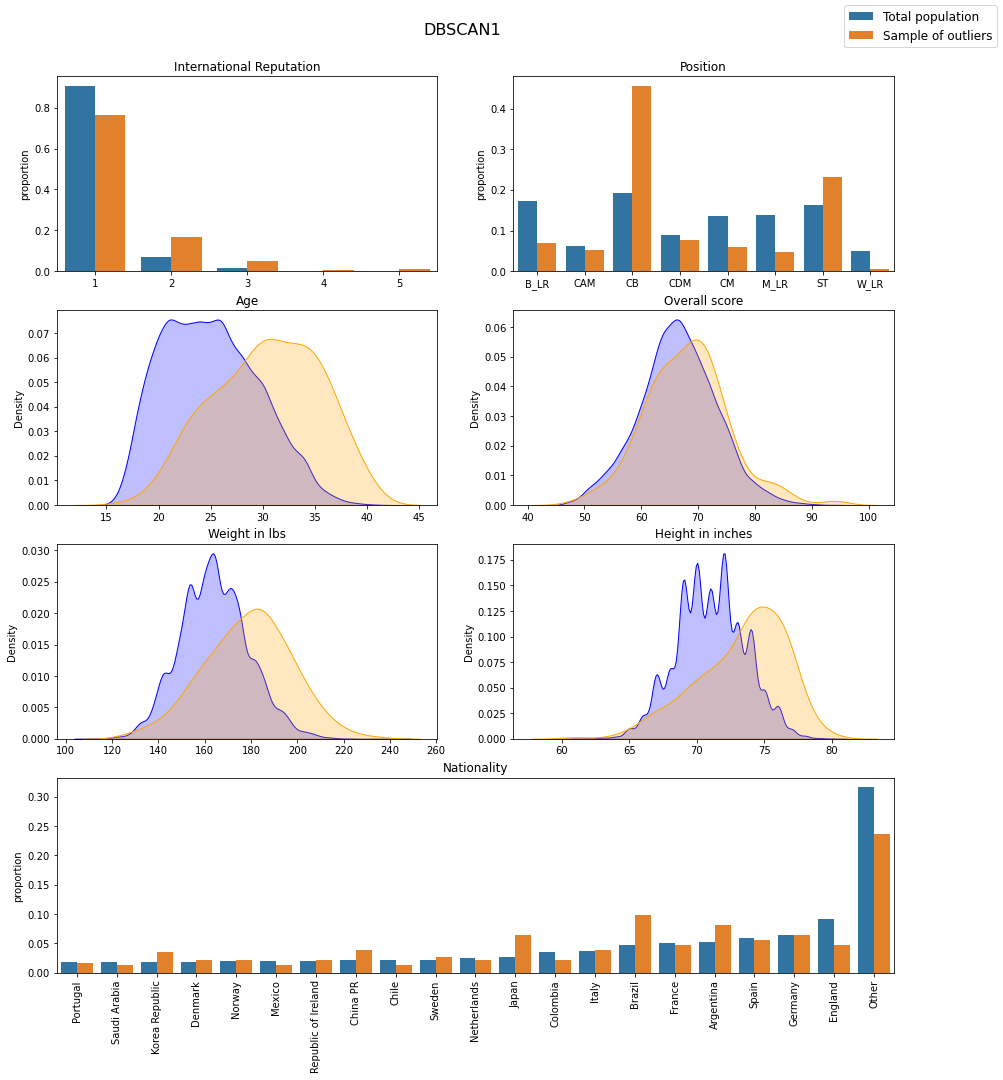

In [28]:
plot_outliers_vs_population(outliers_dbscan1, data, "DBSCAN1")

Now let us model a less strict outlier detection model, with parameters epsilon = 3.25 and min_samples=25, and see how this sample compares to the general population along the dimensions

In [29]:
dbscan2 = DBSCAN(eps=3.25, min_samples=25)
dbscan2.fit(data_attributes_scaled)
outliers_dbscan2 = data[dbscan.labels_==-1]

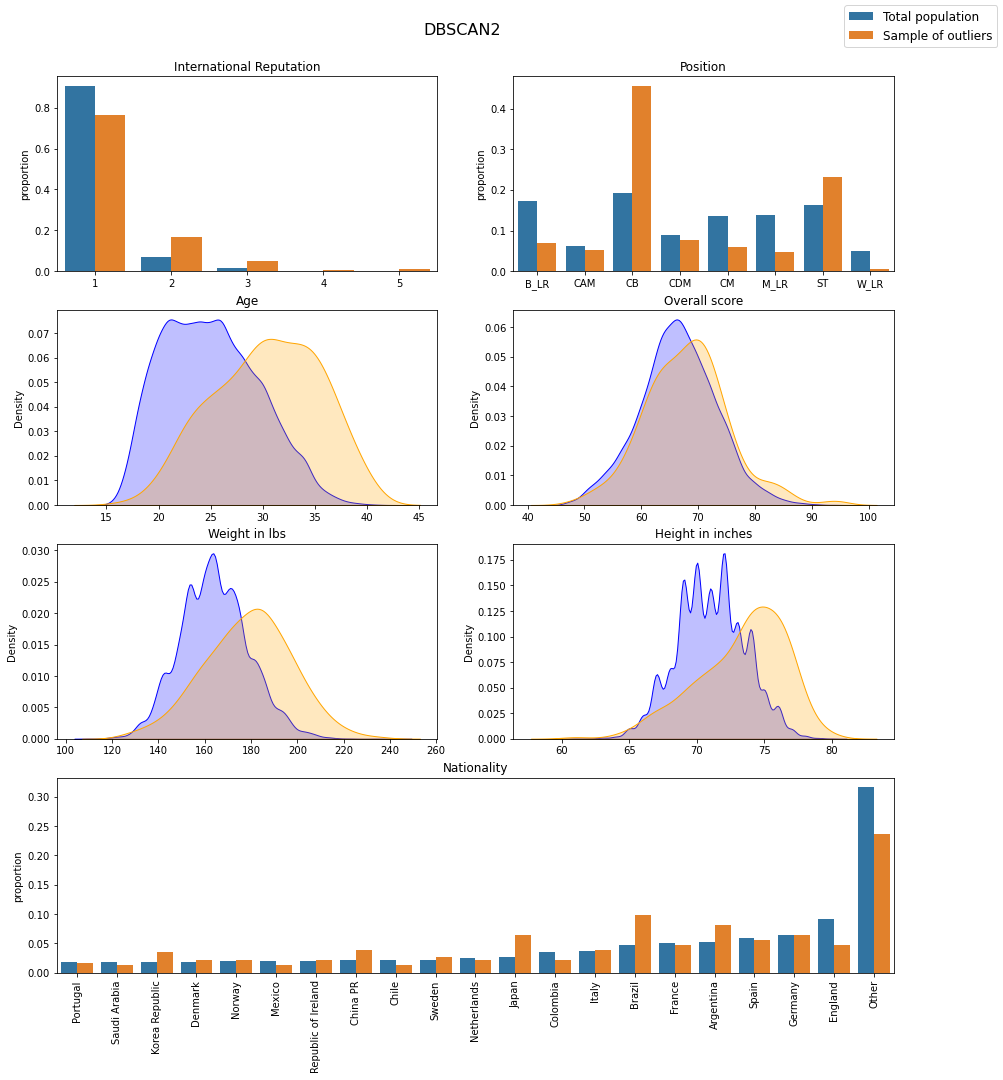

In [30]:
plot_outliers_vs_population(outliers_dbscan2, data, "DBSCAN2")

**Conclusion:** Both DBSCAN methods lead to similar outliers. Compared to the general population, there are relatively more center backs (CB) and strikers (ST) as outliers. Soccer players that are outliers are generally older, larger and heavier. 

### Principal Component Analysis and reconstruction error

The second outlier detection method that I will examine is Principal Component Analysis (PCA) and its reconstruction errors. The idea behind this method is that we reduce the player attribute ratings from the original space to a lower dimensional space, which will result in information loss, and then reconstruct the ratings back to the original space. As information has been lost during this process, the new ratings won't be the same as the original ones. The larger the difference between these ratings, the more likely it is an outlier.

Often this method is used for novelty detection, where the PCA is done on a clean training dataset without any outliers. Then the algorithm can determine for new instances whether they are similar to the training data or not. Autoencoders are also used a lot for novelty detection. However, I will use the method for anomaly detection, where the dataset is contaminated with outliers. The idea is then that the model cannot model outliers that well as the normal instances. 

I will examine 4 of these models, two strict models and two less strict models. For both the strict and the less strict models I reduce the original space to a space of 5 dimensions or to 25 dimensions.

In [31]:
# fitting a PCA model to 5 dimensions
pca_5comp = PCA(n_components=5)
data_pca_5comp = pca_5comp.fit_transform(data_attributes_scaled)

In [32]:
# cumulative sum of the total explained variance ratio
pca_5comp.explained_variance_ratio_.cumsum()

array([0.3908719 , 0.60436016, 0.70346344, 0.76418725, 0.79195977])

As can be seen from above, about 79 percent of the total variance of the attribute ratings is explained by the first five principal components. Let us plot for these components how they load on the original attributes.

Text(0, 0.5, 'Principal components')

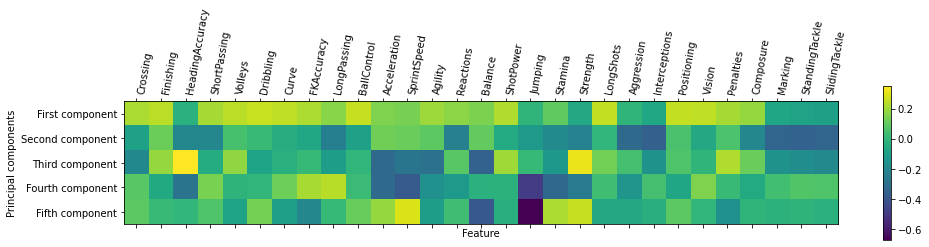

In [33]:
plt.matshow(pca_5comp.components_, cmap="viridis")
plt.yticks([0,1,2,3,4], ["First component", "Second component", "Third component", "Fourth component", "Fifth component"])
plt.colorbar()
plt.xticks(range(len(data_attributes.columns)), data_attributes.columns, rotation=80, ha="left")
plt.xlabel("Feature")
plt.ylabel("Principal components")

Above figure is imformative about what each of the principal components represents. For instance, the first principal component seems to pick up attributes relating to defending (standing tackle, sliding tackle, jumping, interceptions).  

Let us now create a function that can generate reconstruction errors for our four outlier samples.

In [34]:
def reconstruction_ranking(n_components):
    
    pca = PCA(n_components=n_components)
    data_transformed = pca.fit_transform(data_attributes_scaled)
    data_recovered = pca.inverse_transform(data_transformed)
    
    # generate reconstruction errors
    reconstruction_errors = []
    for i in range(data_attributes_scaled.shape[0]):
        reconstruction_error = np.linalg.norm(data_attributes_scaled[i]-data_recovered[i])
        reconstruction_errors.append(reconstruction_error)
    
    # generate ranking based on reconstruction errors
    reconstruction = data.copy()
    reconstruction["reconstruction_error"] = reconstruction_errors
    reconstruction["rank_outlier"] = reconstruction["reconstruction_error"].rank(ascending=False)
    outlier_ranking = reconstruction.sort_values(by="rank_outlier")
   
    return outlier_ranking

In [35]:
outliers_pca_5 = reconstruction_ranking(5)
outliers_pca_25 = reconstruction_ranking(25)

In [36]:
# get outliers with 5 principal components - strict
outliers_pca_5_160 = outliers_pca_5.head(160)
# get outliers with 5 principal component - less strict
outliers_pca_5_800 = outliers_pca_5.head(800)
# get outliers with 25 principal components - strict
outliers_pca_25_160 = outliers_pca_25.head(160)
# get outliers with 25 principal components - less strict
outliers_pca_25_800 = outliers_pca_25.head(800)

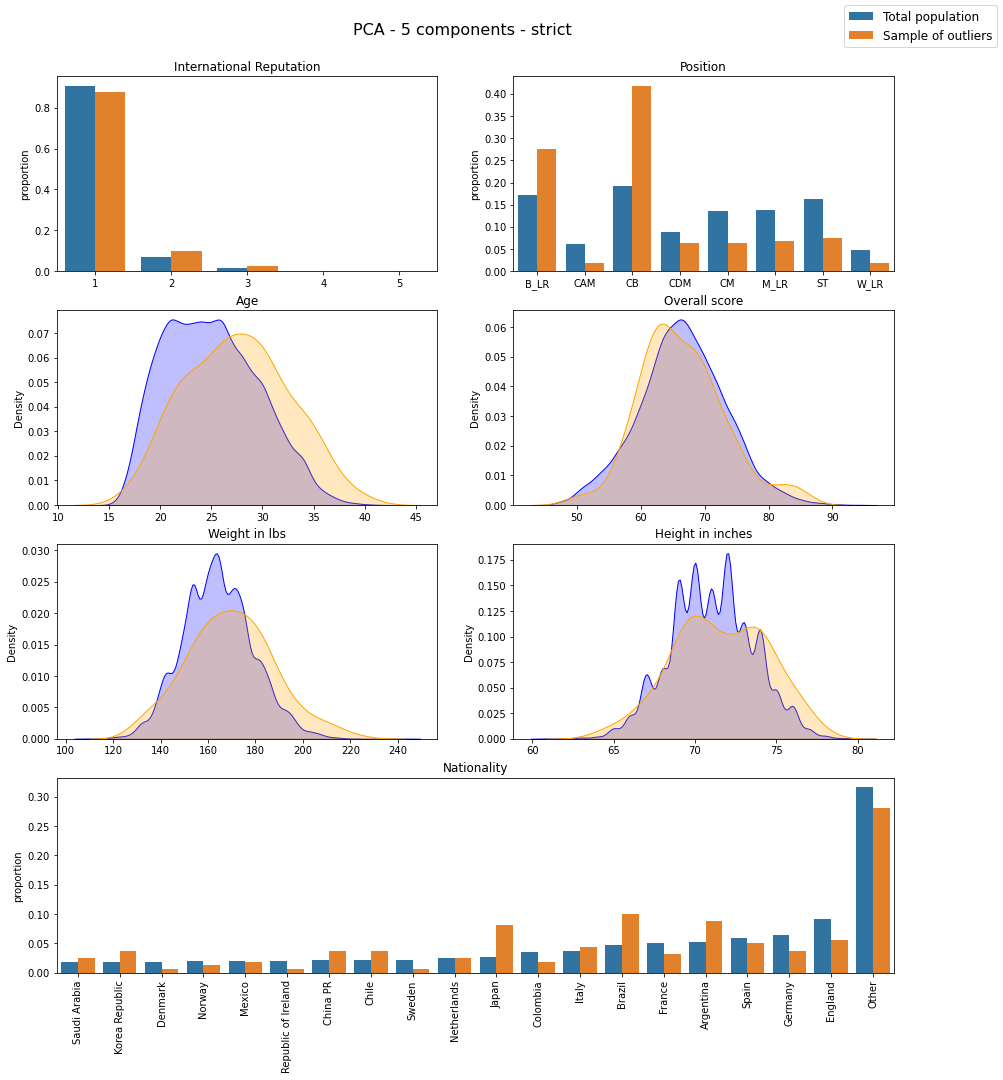

In [37]:
plot_outliers_vs_population(outliers_pca_5_160, data, "PCA - 5 components - strict")

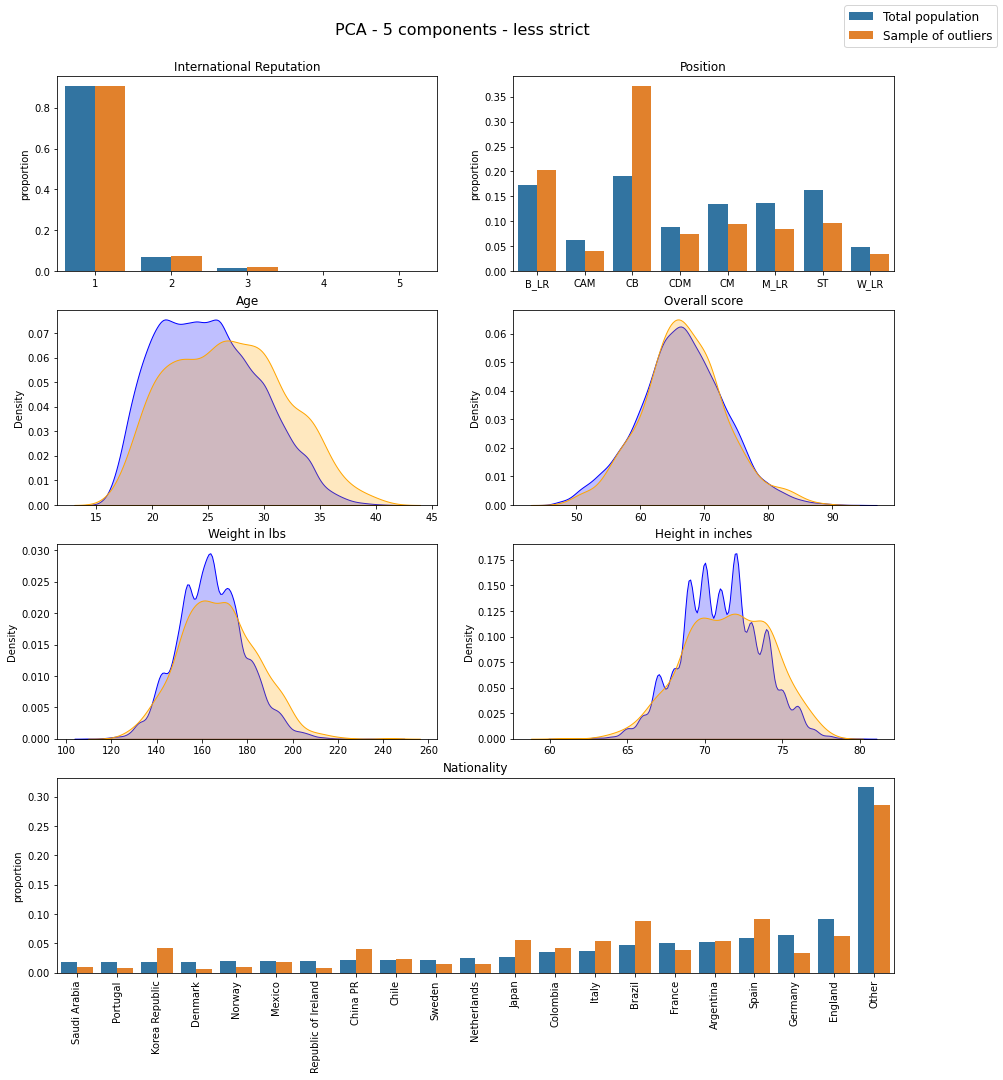

In [38]:
plot_outliers_vs_population(outliers_pca_5_800, data, "PCA - 5 components - less strict")

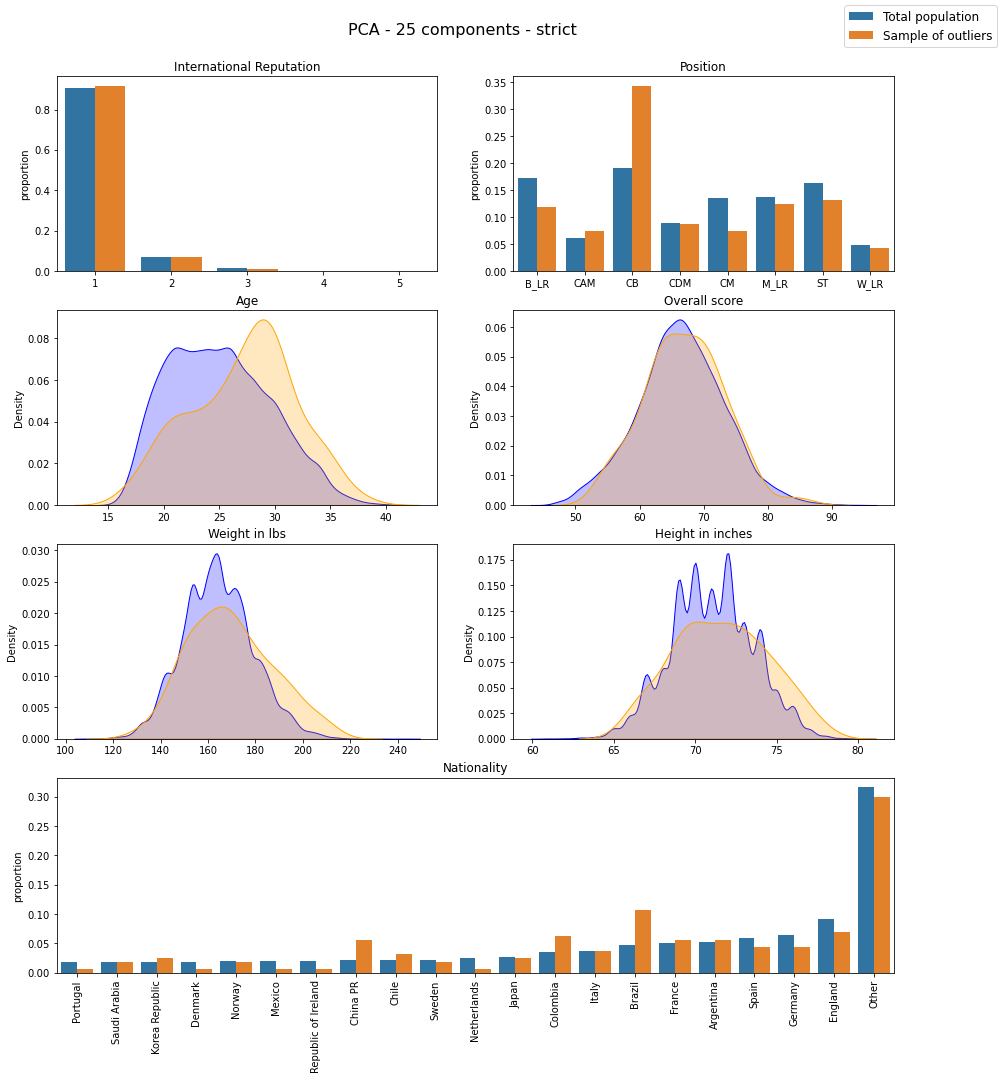

In [39]:
plot_outliers_vs_population(outliers_pca_25_160, data, "PCA - 25 components - strict")

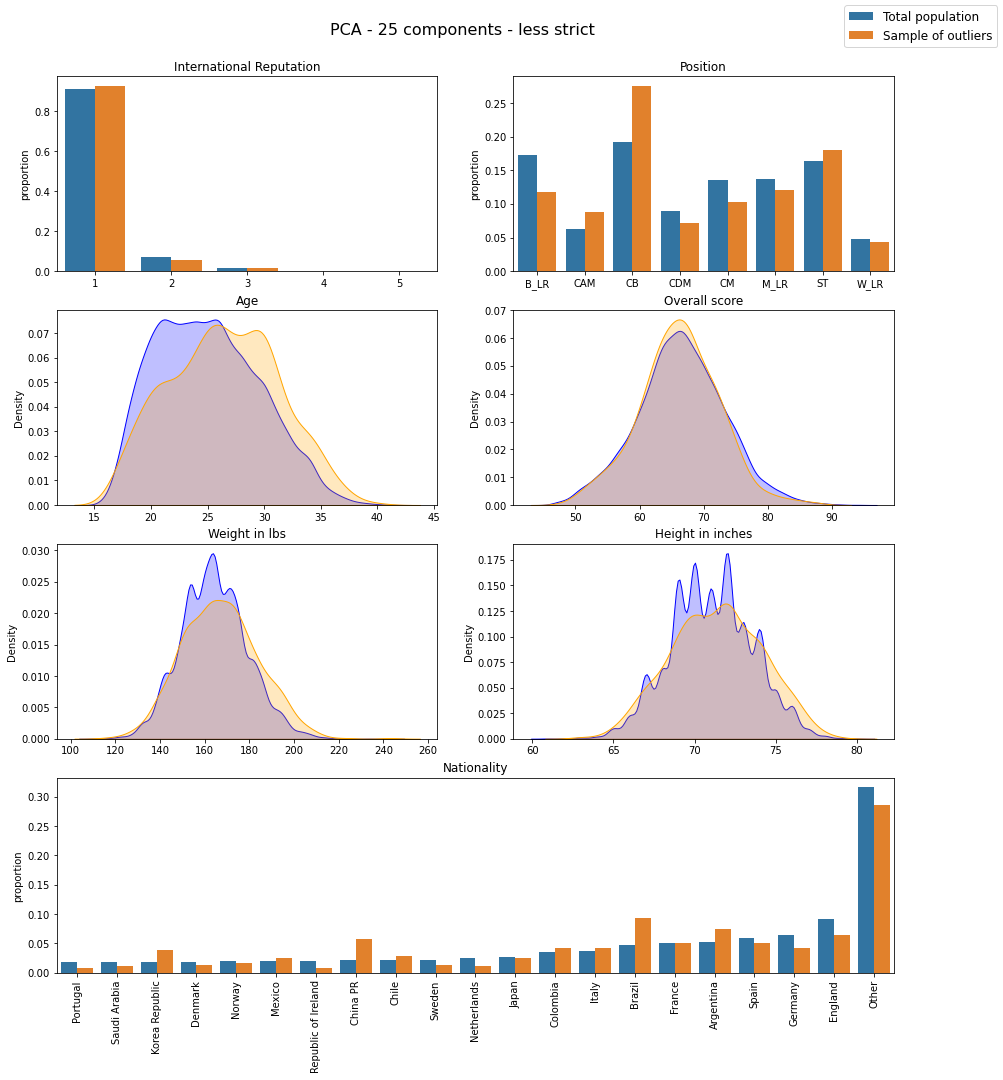

In [40]:
plot_outliers_vs_population(outliers_pca_25_800, data, "PCA - 25 components - less strict")

**Conclusion:** What is very clear is that center backs (Cb) are more among the outliers. Also, if a player is older he is more likely to be considered an outlier. 

### Isolation Forest

This algorithm builds a Random Forest in which each Decision Tree is grown randomly. In this procedures, instances that are outliers are isolated in fewer steps than normal instances. Let's build one Isolation Forest with two contamination levels (proportion of instances that are considered an outlier).

In [41]:
IsoForest_001 = IsolationForest(n_estimators=1000, contamination=0.01, random_state=42)
IsoForest_001.fit(data_attributes)

IsoForest_005 = IsolationForest(n_estimators=1000, contamination=0.05, random_state=42)
IsoForest_005.fit(data_attributes)

IsolationForest(contamination=0.05, n_estimators=1000, random_state=42)

In [42]:
IsoForest_predictions_001 = IsoForest_001.predict(data_attributes)
IsoForest_anomalyscores_001 = IsoForest_001.score_samples(data_attributes)

IsoForest_predictions_005 = IsoForest_005.predict(data_attributes)
IsoForest_anomalyscores_005 = IsoForest_005.score_samples(data_attributes)

In [43]:
# How many outliers for the strict version?
pd.Series(IsoForest_predictions_001).value_counts()

 1    15960
-1      162
dtype: int64

In [44]:
# How many outliers for the less strict version?
pd.Series(IsoForest_predictions_005).value_counts()

 1    15315
-1      807
dtype: int64

In [45]:
# prepare data
IsoForest_data = data.copy()
IsoForest_data["IsoForest_outlier_001"] = IsoForest_predictions_001
IsoForest_data["IsoForest_outlier_005"] = IsoForest_predictions_005
IsoForest_data["IsoForest_anomalyscore"] = IsoForest_anomalyscores_001

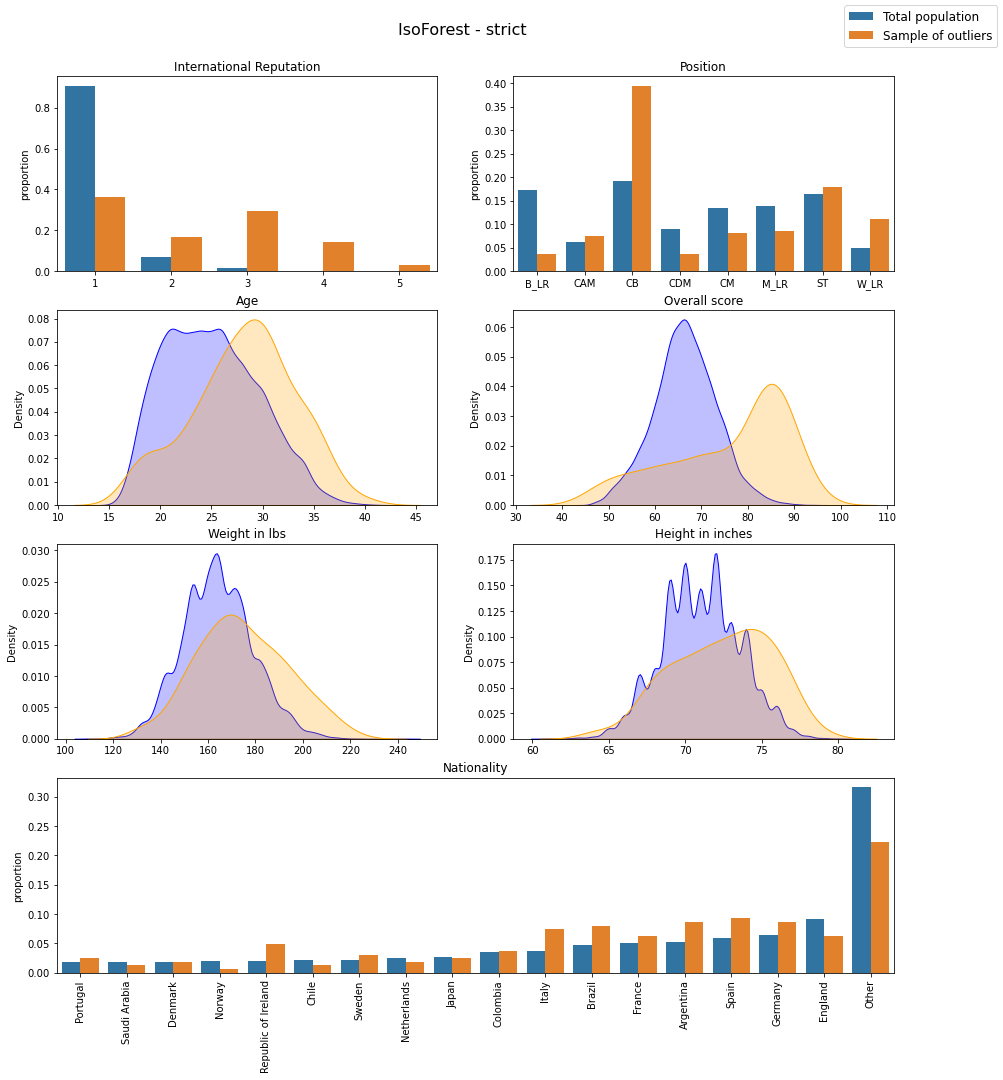

In [46]:
plot_outliers_vs_population(IsoForest_data[IsoForest_data["IsoForest_outlier_001"]==-1], data, "IsoForest - strict")

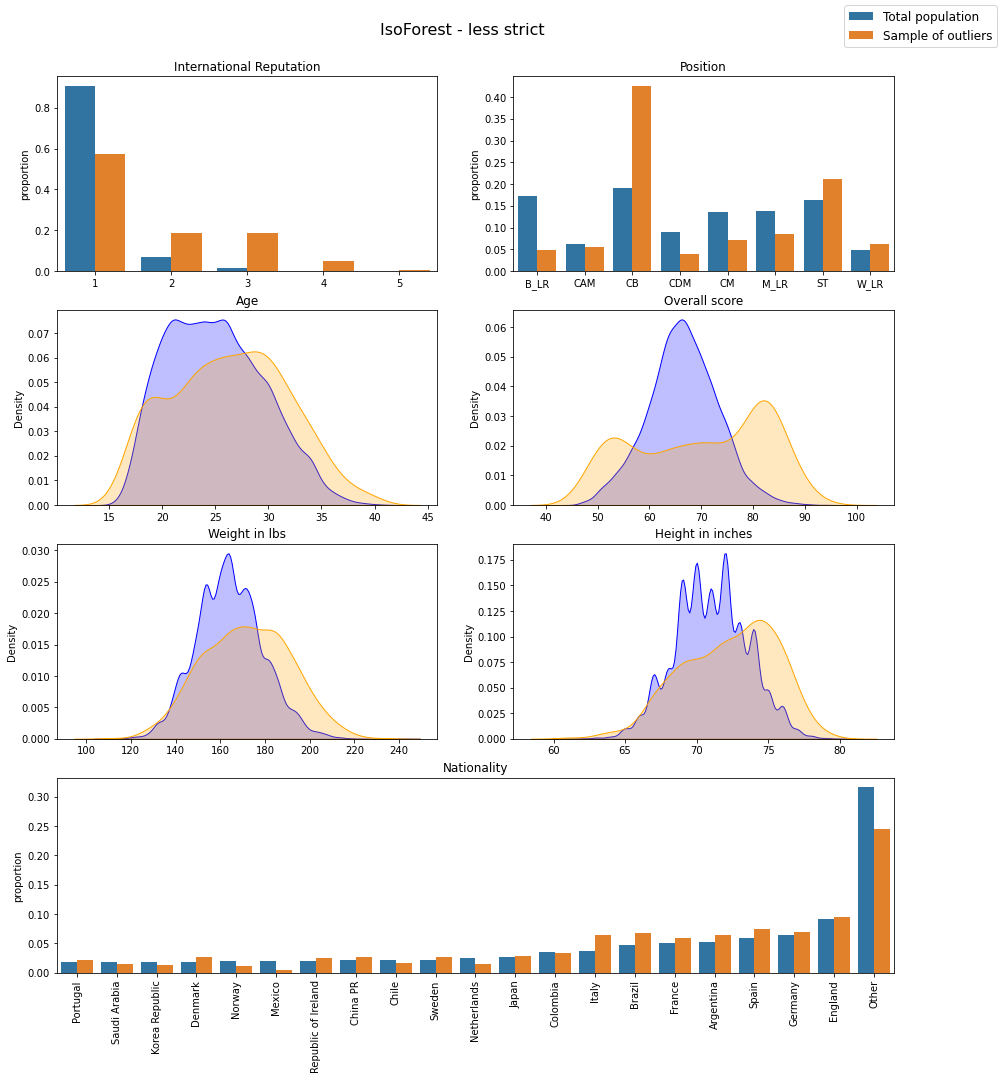

In [47]:
plot_outliers_vs_population(IsoForest_data[IsoForest_data["IsoForest_outlier_005"]==-1], data, "IsoForest - less strict")

**Conclusion:** Isolation Forest seems to generate outliers that are quite different from the population with respect to the examined characteristics. Players are more likely to be outlier if they are centre back (CB), international more famous, are very bad or good, are older, are heavier, are higher, and are from more traditional football countries (not other).

### Minimum covariance determinant

This algorithm assumes that the dataset contains outliers that are not generated from a general Gaussian distribution. When the algorithm estimates this distribution, it will ignore instances that are more likely to be outliers. Let's also use two contamination levels for this algorithm.

In [48]:
cov_001 = EllipticEnvelope(contamination=0.01, random_state=42)
cov_001.fit(data_attributes)

cov_005 = EllipticEnvelope(contamination=0.05, random_state=42)
cov_005.fit(data_attributes)

EllipticEnvelope(contamination=0.05, random_state=42)

In [49]:
cov_predictions_001 = cov_001.predict(data_attributes)
cov_predictions_005 = cov_005.predict(data_attributes)

In [50]:
# How many outliers for the strict version
pd.Series(cov_predictions_001).value_counts()

 1    15960
-1      162
dtype: int64

In [51]:
# How many outliers for the less strict version
pd.Series(cov_predictions_005).value_counts()

 1    15315
-1      807
dtype: int64

In [52]:
cov_scores = cov_001.score_samples(data_attributes)

In [53]:
cov_data = data.copy()
cov_data["cov_outlier_001"] = cov_predictions_001
cov_data["cov_outlier_005"] = cov_predictions_005
cov_data["cov_score"] = cov_scores

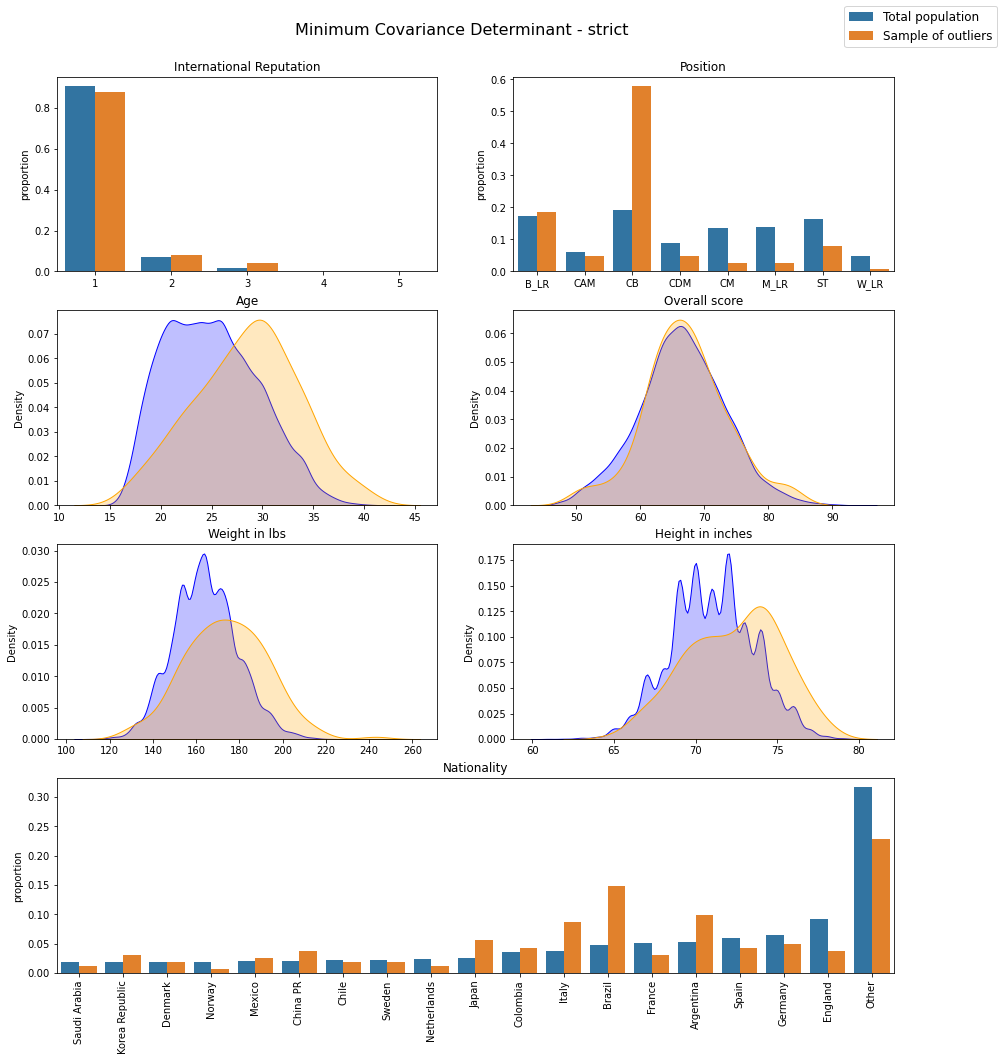

In [54]:
plot_outliers_vs_population(cov_data[cov_data["cov_outlier_001"]==-1], data, "Minimum Covariance Determinant - strict")

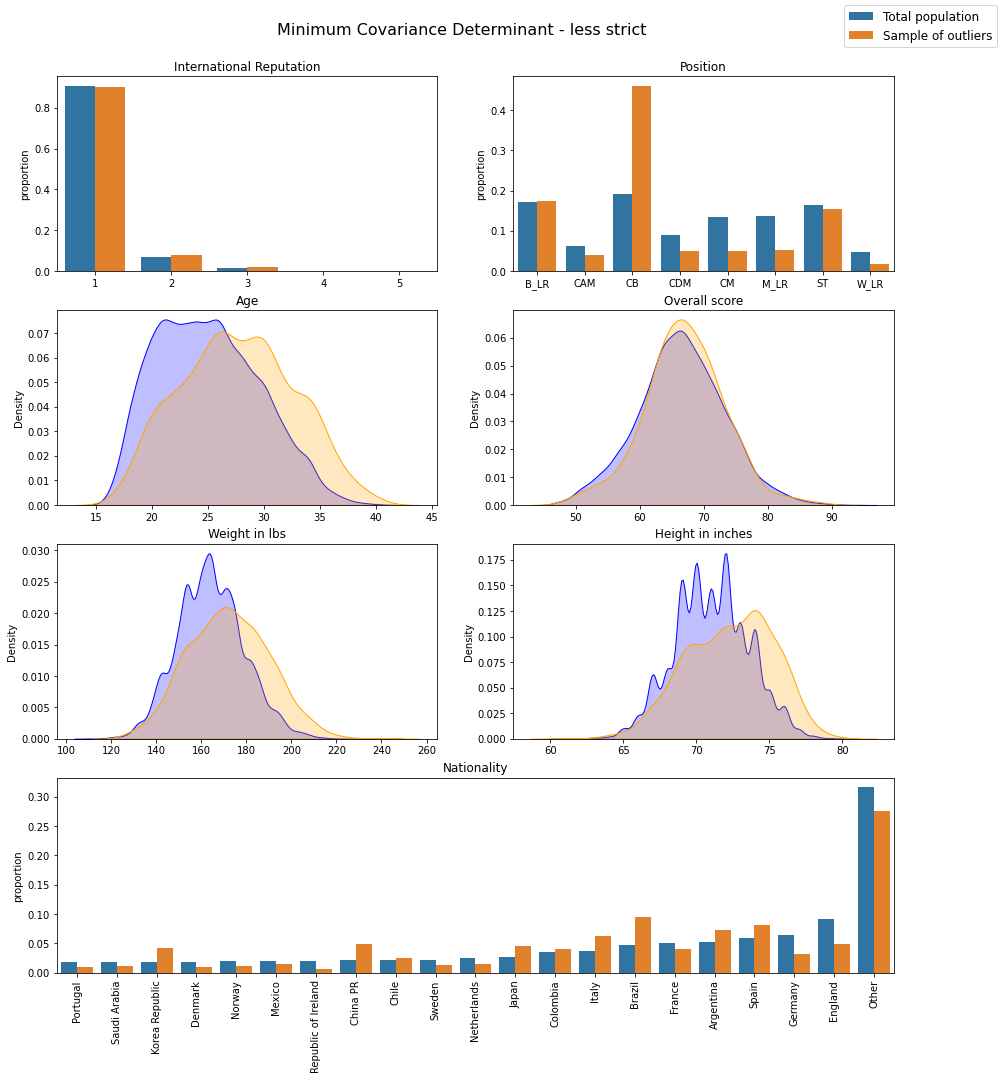

In [55]:
plot_outliers_vs_population(cov_data[cov_data["cov_outlier_005"]==-1], data, "Minimum Covariance Determinant - less strict")

**Conclusion:** Also for this algorithm it is more likely to be the case that a player is an outlier when he is a centre back, when is older, heavier and taller. 

### Local Outlier Factor

Finally, let's consider Local Outlier Factor. This algorithm is based on the idea that outliers are more isolated than its neighbours. The number of neighbours can vary. Let's train a number of Local Outlier Factor models, with different levels of contamination and number of neighbours.

In [56]:
lof_50_001 = LocalOutlierFactor(n_neighbors=50, contamination=0.01)
lof_50_005 = LocalOutlierFactor(n_neighbors=50, contamination=0.05)
lof_100_001 = LocalOutlierFactor(n_neighbors=100, contamination=0.01)
lof_100_005 = LocalOutlierFactor(n_neighbors=100, contamination=0.05)
lof_500_001 = LocalOutlierFactor(n_neighbors=500, contamination=0.01)
lof_500_005 = LocalOutlierFactor(n_neighbors=500, contamination=0.05)

lof_predictions_50_001 = lof_50_001.fit_predict(data_attributes_scaled)
lof_predictions_50_005 = lof_50_005.fit_predict(data_attributes_scaled)
lof_predictions_100_001 = lof_100_001.fit_predict(data_attributes_scaled)
lof_predictions_100_005 = lof_100_005.fit_predict(data_attributes_scaled)
lof_predictions_500_001 = lof_500_001.fit_predict(data_attributes_scaled)
lof_predictions_500_005 = lof_500_005.fit_predict(data_attributes_scaled)

In [57]:
lof_scores_50 = lof_50_001.negative_outlier_factor_
lof_scores_100 = lof_100_001.negative_outlier_factor_
lof_scores_500 = lof_500_001.negative_outlier_factor_

In [58]:
# How many outliers for the strict versions?
pd.Series(lof_predictions_50_001).value_counts()

 1    15960
-1      162
dtype: int64

In [59]:
# How many outliers for the less strict versions?
pd.Series(lof_predictions_50_005).value_counts()

 1    15315
-1      807
dtype: int64

In [60]:
lof_data = data.copy()
lof_data["lof_outlier_50_001"] = lof_predictions_50_001
lof_data["lof_outlier_50_005"] = lof_predictions_50_005
lof_data["lof_outlier_100_001"] = lof_predictions_100_001
lof_data["lof_outlier_100_005"] = lof_predictions_100_005
lof_data["lof_outlier_500_001"] = lof_predictions_500_001
lof_data["lof_outlier_500_005"] = lof_predictions_500_005
lof_data["lof_score_50"] = lof_scores_50
lof_data["lof_score_100"] = lof_scores_100
lof_data["lof_score_500"] = lof_scores_500

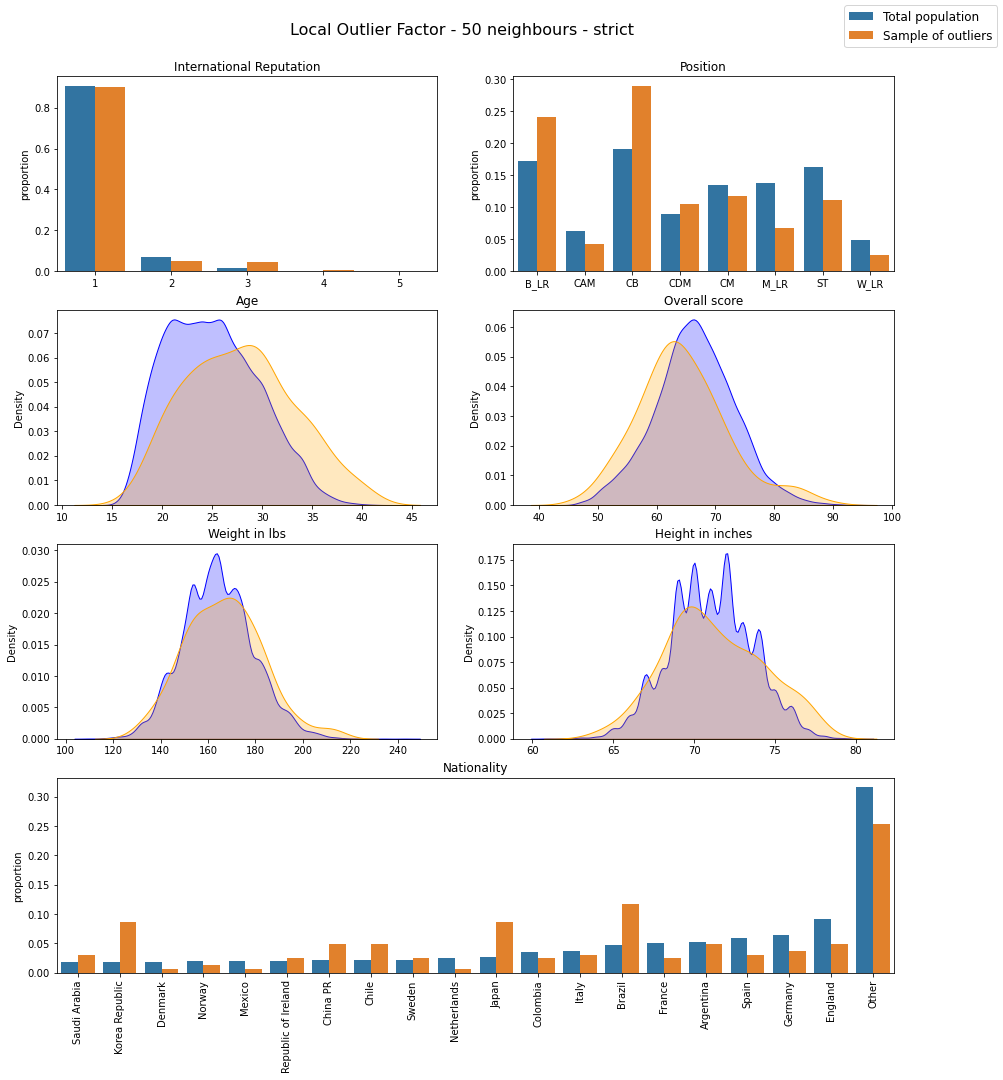

In [61]:
plot_outliers_vs_population(lof_data[lof_data["lof_outlier_50_001"]==-1], data, "Local Outlier Factor - 50 neighbours - strict")

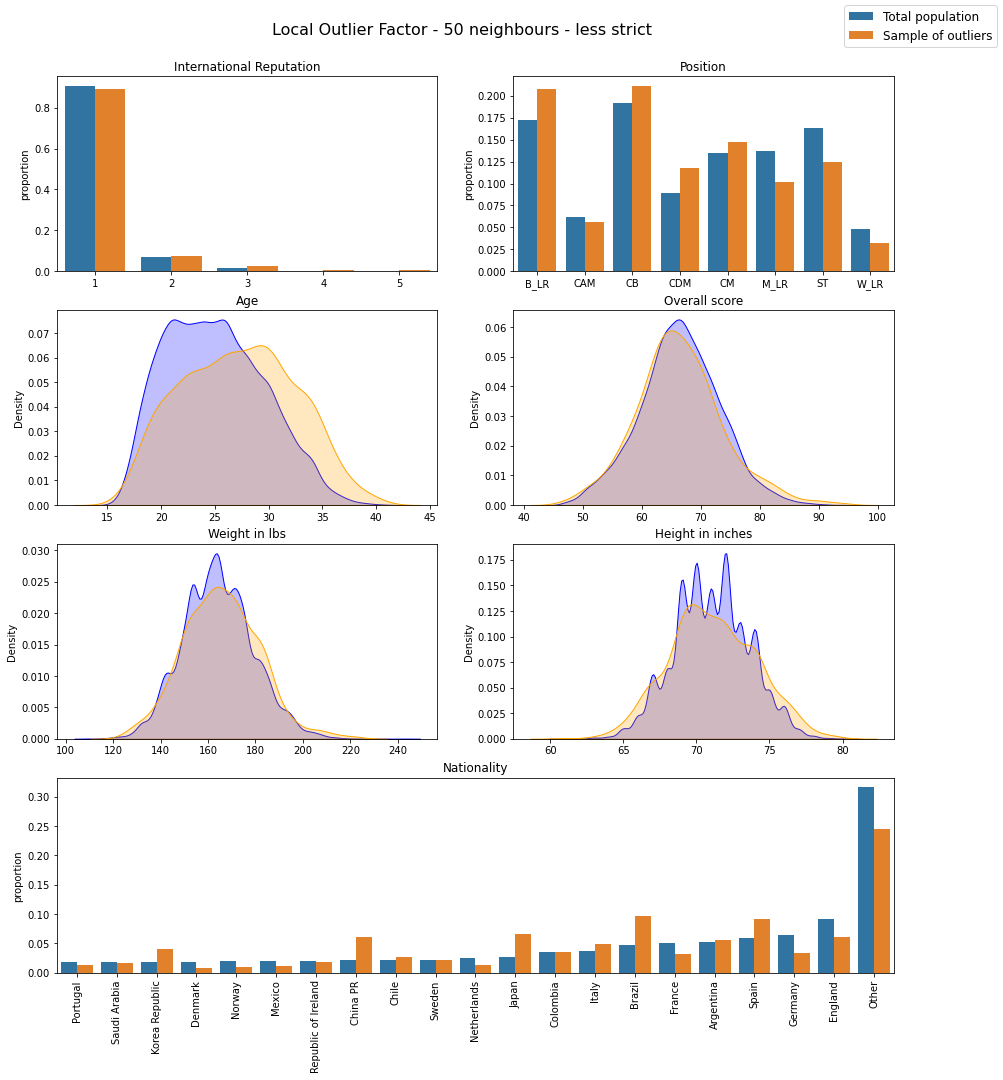

In [62]:
plot_outliers_vs_population(lof_data[lof_data["lof_outlier_50_005"]==-1], data, "Local Outlier Factor - 50 neighbours - less strict")

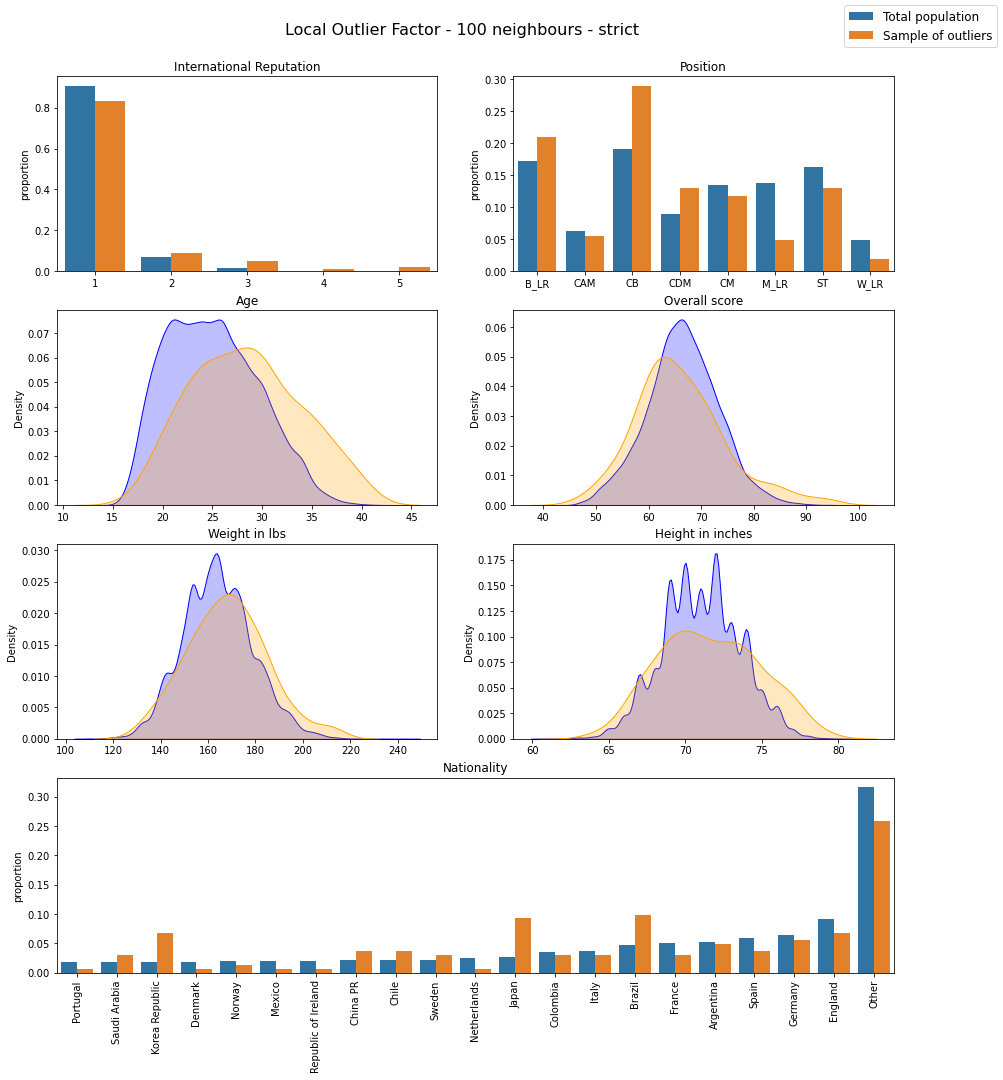

In [63]:
plot_outliers_vs_population(lof_data[lof_data["lof_outlier_100_001"]==-1], data, "Local Outlier Factor - 100 neighbours - strict")

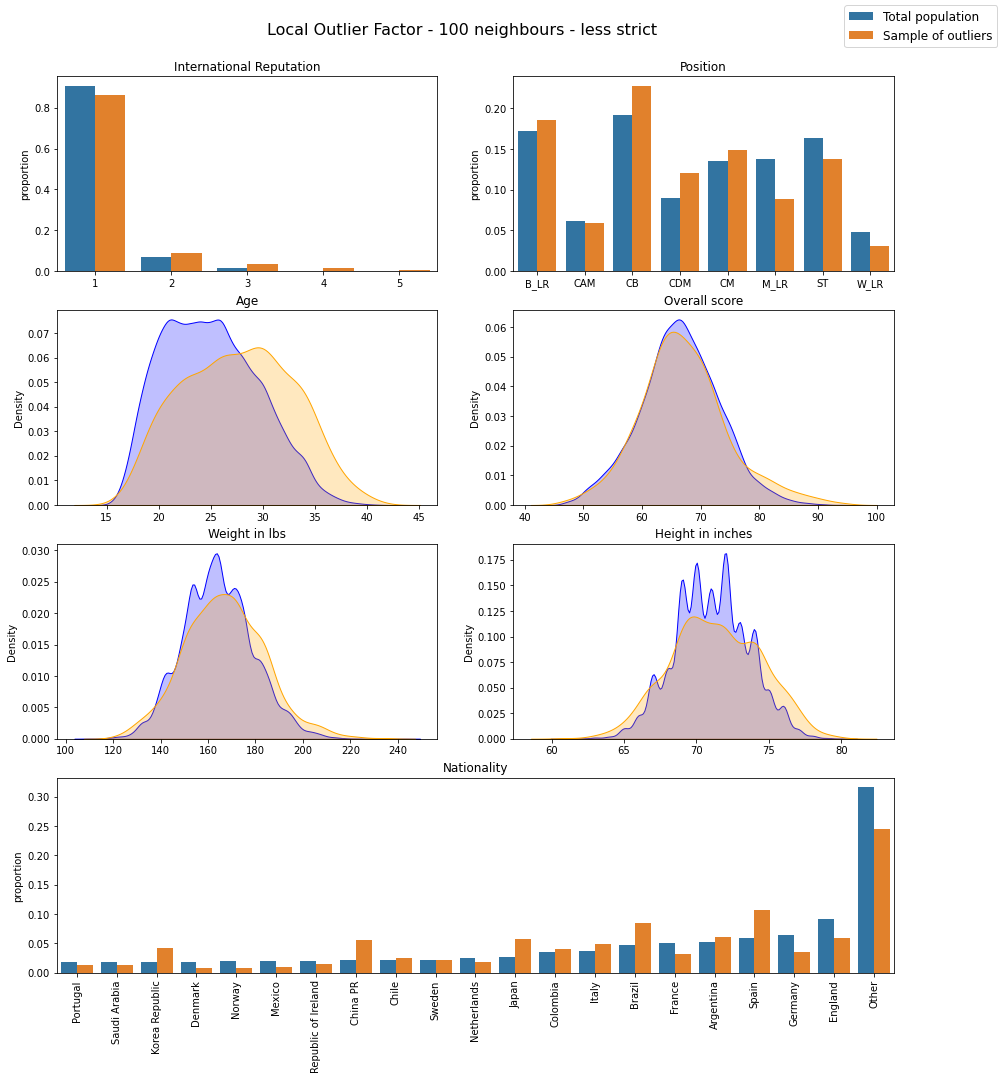

In [64]:
plot_outliers_vs_population(lof_data[lof_data["lof_outlier_100_005"]==-1], data, "Local Outlier Factor - 100 neighbours - less strict")

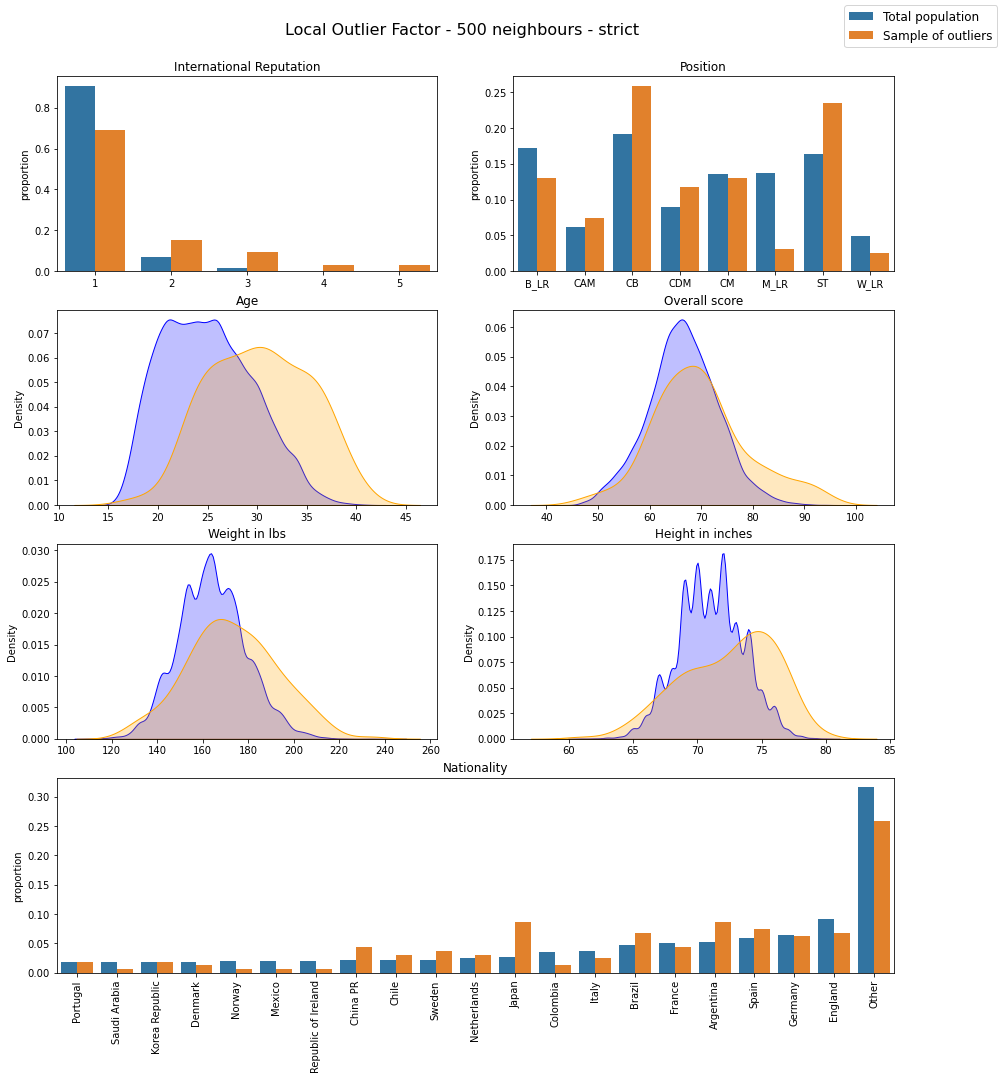

In [65]:
plot_outliers_vs_population(lof_data[lof_data["lof_outlier_500_001"]==-1], data, "Local Outlier Factor - 500 neighbours - strict")

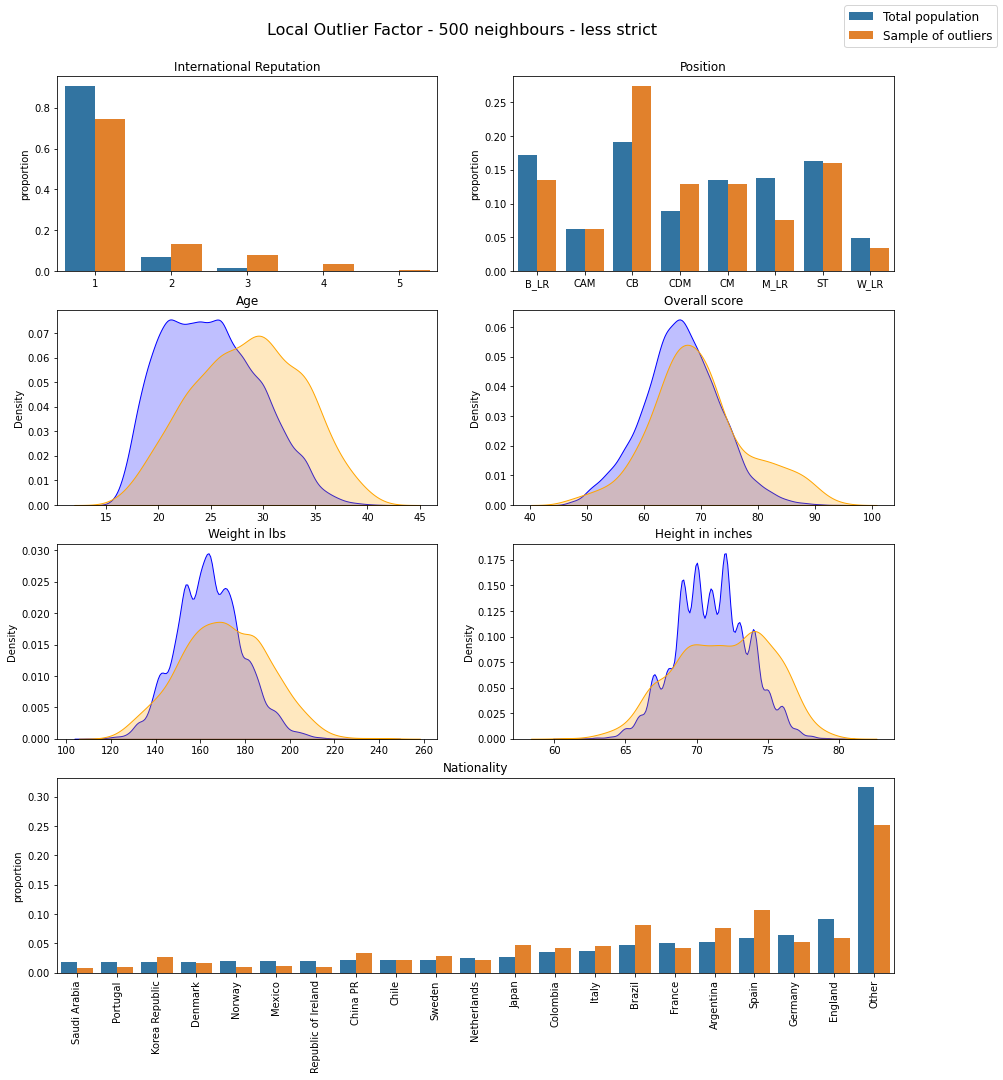

In [66]:
plot_outliers_vs_population(lof_data[lof_data["lof_outlier_500_005"]==-1], data, "Local Outlier Factor - 500 neighbours - less strict")

**Conclusion:** Players are more likely to be an outlier if they are older, centre backs, or if they are more from traditional football countries. Sometimes the likelihood of being an outlier depends on the model.

## Models with outlier removal

In the exploration analysis above we saw that outlier detection models often detect outliers that have different characteristics then the other players. But now I am going to use the methods from above to delete the outliers and see whether this leads to a better prediction model. For the prediction model, I am using a logistic regression, as this doesn't require any hyperparameter tuning. As we deal with a multiclass situation, the algorithm uses a one-versus-rest method. Let's first split the data in a training and a test set, and build the base model (without any outlier deletions).

In [67]:
X_train, X_test, y_train, y_test = train_test_split(data[player_attributes], data["Position"], stratify=data["Position"], random_state=42)

### Outlier removal: base model

In [68]:
pipeline_base = Pipeline([("scaler", StandardScaler()),
                            ('logreg',  LogisticRegression(max_iter = 1000))])

In [69]:
cross_val_score(pipeline_base, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7253325017583776

The accuracy is quite ok. Let's see whether we can improve on this model by deleting those samples that are indicated as outliers. For this I will use the FunctionSampler in the pipeline, that deletes outliers for training, but doesn't delete any samples while predicting.

### Outlier removal: DBSCAN

In [70]:
def outlier_removal_dbscan1(X,y):
    data = X.copy()
    target = y.copy()
    dbscan = DBSCAN(eps=3.75, min_samples=25)
    dbscan.fit(data)
    data = data[dbscan.labels_!=-1]
    target = target[dbscan.labels_!=-1]
    return data, target
    
def outlier_removal_dbscan2(X,y):
    data = X.copy()
    target = y.copy()
    dbscan = DBSCAN(eps=3.25, min_samples=25)
    dbscan.fit(data)
    data = data[dbscan.labels_!=-1]
    target = target[dbscan.labels_!=-1]
    return data, target    

pipeline_dbscan1 = Pipeline([("scaler", StandardScaler()),
                            ('outlier_removal_dbscan1', FunctionSampler(func=outlier_removal_dbscan1, validate = False)),
                            ('logreg',  LogisticRegression(max_iter = 1000))])

pipeline_dbscan2 = Pipeline([("scaler", StandardScaler()),
                            ('outlier_removal_dbscan2', FunctionSampler(func=outlier_removal_dbscan2, validate = False)),
                            ('logreg',  LogisticRegression(max_iter = 1000))])


In [71]:
cross_val_score(pipeline_dbscan1, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7244227956852475

In [72]:
cross_val_score(pipeline_dbscan2, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7266558069542508

When a few outliers are deleted (the first case) the performance detoriates slightly, but when more outliers are deleted (the second case) the performance improved slightly.

### Outlier removal: Principal Component Analysis and reconstruction error

In [73]:
def outlier_removal_pca_5_001(X,y):
    data = X.copy()
    target = y.copy()
    pca = PCA(n_components=5)
    data_transformed = pca.fit_transform(data)
    data_recovered = pca.inverse_transform(data_transformed)
    
    reconstruction_errors = []
    for i in range(data.shape[0]):
        reconstruction_error = np.linalg.norm(data[i]-data_recovered[i])
        reconstruction_errors.append(reconstruction_error)

    reconstruction_errors = np.array(reconstruction_errors)
    sorted_indices = np.argsort(-reconstruction_errors)
    ranks = np.empty_like(sorted_indices)
    ranks[sorted_indices] = np.arange(len(reconstruction_errors))
    ranks = ranks / len(reconstruction_errors)
    
    return data[ranks>=0.01], target[ranks>=0.01]

def outlier_removal_pca_5_005(X,y):
    data = X.copy()
    target = y.copy()
    pca = PCA(n_components=5)
    data_transformed = pca.fit_transform(data)
    data_recovered = pca.inverse_transform(data_transformed)
    
    reconstruction_errors = []
    for i in range(data.shape[0]):
        reconstruction_error = np.linalg.norm(data[i]-data_recovered[i])
        reconstruction_errors.append(reconstruction_error)

    reconstruction_errors = np.array(reconstruction_errors)
    sorted_indices = np.argsort(-reconstruction_errors)
    ranks = np.empty_like(sorted_indices)
    ranks[sorted_indices] = np.arange(len(reconstruction_errors))
    ranks = ranks / len(reconstruction_errors)
    
    return data[ranks>=0.05], target[ranks>=0.05]

def outlier_removal_pca_25_001(X,y):
    data = X.copy()
    target = y.copy()
    pca = PCA(n_components=25)
    data_transformed = pca.fit_transform(data)
    data_recovered = pca.inverse_transform(data_transformed)
    
    reconstruction_errors = []
    for i in range(data.shape[0]):
        reconstruction_error = np.linalg.norm(data[i]-data_recovered[i])
        reconstruction_errors.append(reconstruction_error)

    reconstruction_errors = np.array(reconstruction_errors)
    sorted_indices = np.argsort(-reconstruction_errors)
    ranks = np.empty_like(sorted_indices)
    ranks[sorted_indices] = np.arange(len(reconstruction_errors))
    ranks = ranks / len(reconstruction_errors)
    
    return data[ranks>=0.01], target[ranks>=0.01]

def outlier_removal_pca_25_005(X,y):
    data = X.copy()
    target = y.copy()
    pca = PCA(n_components=25)
    data_transformed = pca.fit_transform(data)
    data_recovered = pca.inverse_transform(data_transformed)
    
    reconstruction_errors = []
    for i in range(data.shape[0]):
        reconstruction_error = np.linalg.norm(data[i]-data_recovered[i])
        reconstruction_errors.append(reconstruction_error)

    reconstruction_errors = np.array(reconstruction_errors)
    sorted_indices = np.argsort(-reconstruction_errors)
    ranks = np.empty_like(sorted_indices)
    ranks[sorted_indices] = np.arange(len(reconstruction_errors))
    ranks = ranks / len(reconstruction_errors)
    
    return data[ranks>=0.05], target[ranks>=0.05]

pipeline_pca_5_001 = Pipeline([("scaler", StandardScaler()),
                            ('outlier_removal_pca_5_001', FunctionSampler(func=outlier_removal_pca_5_001, validate = False)),
                            ('logreg',  LogisticRegression(max_iter = 1000))])

pipeline_pca_5_005 = Pipeline([("scaler", StandardScaler()),
                            ('outlier_removal_pca_5_005', FunctionSampler(func=outlier_removal_pca_5_005, validate = False)),
                            ('logreg',  LogisticRegression(max_iter = 1000))])

pipeline_pca_25_001 = Pipeline([("scaler", StandardScaler()),
                            ('outlier_removal_pca_25_001', FunctionSampler(func=outlier_removal_pca_25_001, validate = False)),
                            ('logreg',  LogisticRegression(max_iter = 1000))])

pipeline_pca_25_005 = Pipeline([("scaler", StandardScaler()),
                            ('outlier_removal_pca_25_005', FunctionSampler(func=outlier_removal_pca_25_005, validate = False)),
                            ('logreg',  LogisticRegression(max_iter = 1000))])


In [74]:
cross_val_score(pipeline_pca_5_001, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7245882900432233

In [75]:
cross_val_score(pipeline_pca_5_005, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7250016840076715

In [76]:
cross_val_score(pipeline_pca_25_001, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7248361896496957

In [77]:
cross_val_score(pipeline_pca_25_005, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7240918411623448

All four these methods lead to lower accuracy scores compared to the base model 

### Outlier removal: Isolation Forest

In [78]:
def outlier_removal_isoforest_001(X,y):
    data = X.copy()
    target = y.copy()
    
    IsoForest_001 = IsolationForest(n_estimators=1000, contamination=0.01, random_state=42)
    IsoForest_001.fit(data)
    IsoForest_predictions_001 = IsoForest_001.predict(data)
    
    return data[IsoForest_predictions_001==1], target[IsoForest_predictions_001==1]

def outlier_removal_isoforest_005(X,y):
    data = X.copy()
    target = y.copy()
    
    IsoForest_005 = IsolationForest(n_estimators=1000, contamination=0.05, random_state=42)
    IsoForest_005.fit(data)
    IsoForest_predictions_005 = IsoForest_005.predict(data)
    
    return data[IsoForest_predictions_005==1], target[IsoForest_predictions_005==1]


pipeline_isoforest_001 = Pipeline([('outlier_removal_isoforest_001', FunctionSampler(func=outlier_removal_isoforest_001, validate = False)),
                                   ("scaler", StandardScaler()),
                                   ('logreg',  LogisticRegression(max_iter = 1000))])

pipeline_isoforest_005 = Pipeline([('outlier_removal_isoforest_005', FunctionSampler(func=outlier_removal_isoforest_005, validate = False)),
                                   ("scaler", StandardScaler()),
                                   ('logreg',  LogisticRegression(max_iter = 1000))])

In [79]:
cross_val_score(pipeline_isoforest_001, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7257460324950223

In [80]:
cross_val_score(pipeline_isoforest_005, X_train, y_train, cv=5, scoring="accuracy").mean()

0.725084738924102

Both these outlier detection methods lead to similar accuracy scores compared with the base model. One is slightly lower, one is slightly higher.

### Outlier removal: Minimum covariance determinant

In [81]:
def outlier_removal_cov_001(X,y):
    data = X.copy()
    target = y.copy()
    
    cov_001 = EllipticEnvelope(contamination=0.01, random_state=42)
    cov_001.fit(data)
    cov_predictions_001 = cov_001.predict(data)
    
    return data[cov_predictions_001==1], target[cov_predictions_001==1]
    
def outlier_removal_cov_005(X,y):
    data = X.copy()
    target = y.copy()
    
    cov_005 = EllipticEnvelope(contamination=0.05, random_state=42)
    cov_005.fit(data)
    cov_predictions_005 = cov_005.predict(data)
    
    return data[cov_predictions_005==1], target[cov_predictions_005==1]

pipeline_cov_001 = Pipeline([('outlier_removal_cov_001', FunctionSampler(func=outlier_removal_cov_001, validate = False)),
                                   ("scaler", StandardScaler()),
                                   ('logreg',  LogisticRegression(max_iter = 1000))])

pipeline_cov_005 = Pipeline([('outlier_removal_cov_005', FunctionSampler(func=outlier_removal_cov_005, validate = False)),
                                   ("scaler", StandardScaler()),
                                   ('logreg',  LogisticRegression(max_iter = 1000))])

In [82]:
cross_val_score(pipeline_cov_001, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7246709346430639

In [83]:
cross_val_score(pipeline_cov_005, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7250018207798682

Also for these methods, the accuracy scores are slightly lower than the accuracy score of the base model.

### Outlier removal: Local Outlier Factor

In [84]:
def outlier_removal_lof_50_001(X,y):
    data = X.copy()
    target = y.copy()
    lof_50_001 = LocalOutlierFactor(n_neighbors=50, contamination=0.01)
    lof_predictions_50_001 = lof_50_001.fit_predict(data)
    return data[lof_predictions_50_001==1], target[lof_predictions_50_001==1]

def outlier_removal_lof_50_005(X,y):
    data = X.copy()
    target = y.copy()
    lof_50_005 = LocalOutlierFactor(n_neighbors=50, contamination=0.05)
    lof_predictions_50_005 = lof_50_005.fit_predict(data)
    return data[lof_predictions_50_005==1], target[lof_predictions_50_005==1]

def outlier_removal_lof_100_001(X,y):
    data = X.copy()
    target = y.copy()
    lof_100_001 = LocalOutlierFactor(n_neighbors=100, contamination=0.01)
    lof_predictions_100_001 = lof_100_001.fit_predict(data)
    return data[lof_predictions_100_001==1], target[lof_predictions_100_001==1]

def outlier_removal_lof_100_005(X,y):
    data = X.copy()
    target = y.copy()
    lof_100_005 = LocalOutlierFactor(n_neighbors=100, contamination=0.05)
    lof_predictions_100_005 = lof_100_005.fit_predict(data)
    return data[lof_predictions_100_005==1], target[lof_predictions_100_005==1]

def outlier_removal_lof_500_001(X,y):
    data = X.copy()
    target = y.copy()
    lof_500_001 = LocalOutlierFactor(n_neighbors=500, contamination=0.01)
    lof_predictions_500_001 = lof_500_001.fit_predict(data)
    return data[lof_predictions_500_001==1], target[lof_predictions_500_001==1]

def outlier_removal_lof_500_005(X,y):
    data = X.copy()
    target = y.copy()
    lof_500_005 = LocalOutlierFactor(n_neighbors=500, contamination=0.05)
    lof_predictions_500_005 = lof_500_005.fit_predict(data)
    return data[lof_predictions_500_005==1], target[lof_predictions_500_005==1]

pipeline_lof_50_001 = Pipeline([("scaler", StandardScaler()),
                                ('outlier_removal_lof_50_001', FunctionSampler(func=outlier_removal_lof_50_001, validate = False)),
                                ('logreg',  LogisticRegression(max_iter = 1000))])

pipeline_lof_50_005 = Pipeline([("scaler", StandardScaler()),
                                ('outlier_removal_lof_50_005', FunctionSampler(func=outlier_removal_lof_50_005, validate = False)),
                                ('logreg',  LogisticRegression(max_iter = 1000))])

pipeline_lof_100_001 = Pipeline([("scaler", StandardScaler()),
                                ('outlier_removal_lof_100_001', FunctionSampler(func=outlier_removal_lof_100_001, validate = False)),
                                ('logreg',  LogisticRegression(max_iter = 1000))])

pipeline_lof_100_005 = Pipeline([("scaler", StandardScaler()),
                                ('outlier_removal_lof_100_005', FunctionSampler(func=outlier_removal_lof_100_005, validate = False)),
                                ('logreg',  LogisticRegression(max_iter = 1000))])

pipeline_lof_500_001 = Pipeline([("scaler", StandardScaler()),
                                ('outlier_removal_lof_500_001', FunctionSampler(func=outlier_removal_lof_500_001, validate = False)),
                                ('logreg',  LogisticRegression(max_iter = 1000))])

pipeline_lof_500_005 = Pipeline([("scaler", StandardScaler()),
                                ('outlier_removal_lof_500_005', FunctionSampler(func=outlier_removal_lof_500_005, validate = False)),
                                ('logreg',  LogisticRegression(max_iter = 1000))])


In [85]:
cross_val_score(pipeline_lof_50_001, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7248362922288432

In [86]:
cross_val_score(pipeline_lof_50_005, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7260770554040233

In [87]:
cross_val_score(pipeline_lof_100_001, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7245881532710267

In [88]:
cross_val_score(pipeline_lof_100_005, X_train, y_train, cv=5, scoring="accuracy").mean()

0.725911253308605

In [89]:
cross_val_score(pipeline_lof_500_001, X_train, y_train, cv=5, scoring="accuracy").mean()

0.724753716015101

In [90]:
cross_val_score(pipeline_lof_500_005, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7250844311866596

Compared with the base model, these methods sometimes lead to better accuracy and sometimes to lower accuracy.

## Final prediction model

In this dataset, outliers do not seem to have a big influence on the performance of the model. Nevertheless, I will take the best method (with the highest accuracy on the validation set) and work from there. This is the second dbscan model.

In [91]:
# Set up pipeline
pipeline_dbscan2 = Pipeline([("scaler", StandardScaler()),
                            ('outlier_removal_dbscan2', FunctionSampler(func=outlier_removal_dbscan2, validate = False)),
                            ('logreg',  LogisticRegression(max_iter = 1000))])

In [92]:
pipeline_dbscan2.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('outlier_removal_dbscan2',
                 FunctionSampler(func=<function outlier_removal_dbscan2 at 0x000002EA03B7CA68>,
                                 validate=False)),
                ('logreg', LogisticRegression(max_iter=1000))])

In [93]:
# accuracy score on training set
predictions_train = pipeline_dbscan2.predict(X_train)
accuracy_score(predictions_train, y_train)

0.7328591514349516

In [94]:
# accuracy score on test set
predictions = pipeline_dbscan2.predict(X_test)
accuracy_score(predictions, y_test)

0.7164475316298685

The model we chose has a lower accuracy score for the test set compared with the training set.

Now let's find out what the best positions are for some of the players, what the second best positions are etc.!

In [95]:
# possible classes
pipeline_dbscan2.classes_

array(['B_LR', 'CAM', 'CB', 'CDM', 'CM', 'M_LR', 'ST', 'W_LR'],
      dtype=object)

In [96]:
# define function that prints out the (next) best positions based on the final model

def print_next_best_positions(list_of_names):
    
    df = pd.DataFrame()
    
    for name in list_of_names:
        row = data.loc[data["Name"]==name, player_attributes]
        actual_position = data.loc[data["Name"]==name, "Position"].values[0]
        probas = pipeline_dbscan2.predict_proba(row)
        probas = probas[0]
        sorted_indices = np.argsort(-probas)
        
        predicted_positions = []
        probabilities = []
        for index in sorted_indices:
            predicted_positions.append(pipeline_dbscan2.classes_[index])
            probabilities.append(probas[index])
        
        print(f"Player: {name}:")
        print(f"Actual position: {actual_position}")
        print(f"Best position: {predicted_positions[0]} with probability {probabilities[0]:.3f}")
        print(f"Second position: {predicted_positions[1]} with probability {probabilities[1]:.3f}")
        print(f"Third position: {predicted_positions[2]} with probability {probabilities[2]:.3f}")
        print("---------------------------------------------------------")


In [97]:
print_next_best_positions(["L. Messi", "K. De Bruyne", "Cristiano Ronaldo"])

Player: L. Messi:
Actual position: W_LR
Best position: CAM with probability 0.631
Second position: ST with probability 0.148
Third position: W_LR with probability 0.126
---------------------------------------------------------
Player: K. De Bruyne:
Actual position: CM
Best position: CM with probability 0.432
Second position: CAM with probability 0.283
Third position: M_LR with probability 0.239
---------------------------------------------------------
Player: Cristiano Ronaldo:
Actual position: ST
Best position: ST with probability 0.931
Second position: W_LR with probability 0.034
Third position: M_LR with probability 0.029
---------------------------------------------------------


Interestingly, L. Messi should be a CAM according to the model, while is actual position is winger. Christiano Ronaldo is a striker with almost absolute certainty!